### Imports

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures,MinMaxScaler
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,plot_confusion_matrix
from sklearn.linear_model import LinearRegression,Ridge,ElasticNet,Lasso,Perceptron
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC,LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

### Reading data

In [160]:
Tr_data =  pd.read_pickle ('train.pkl')

# Cleaning the column names
columns = Tr_data.columns
for col in columns:
    Tr_data = Tr_data.rename(
        columns={
            # strip out parentheses, and their contents
            col: re.sub(r'\(.*', '', col)
            .strip() 
            .replace(' ', '_')
            .replace('-', '_') 
            .lower()  # lowercase the column name
        }
    )
df = Tr_data.copy()

# Removal of all values that has missing in to be able to see the visualisations.
missing_values = df[df.eq('missing').any(1)]
df = df.drop(df.index[list(missing_values.index)])

### Data exploration and visualisation

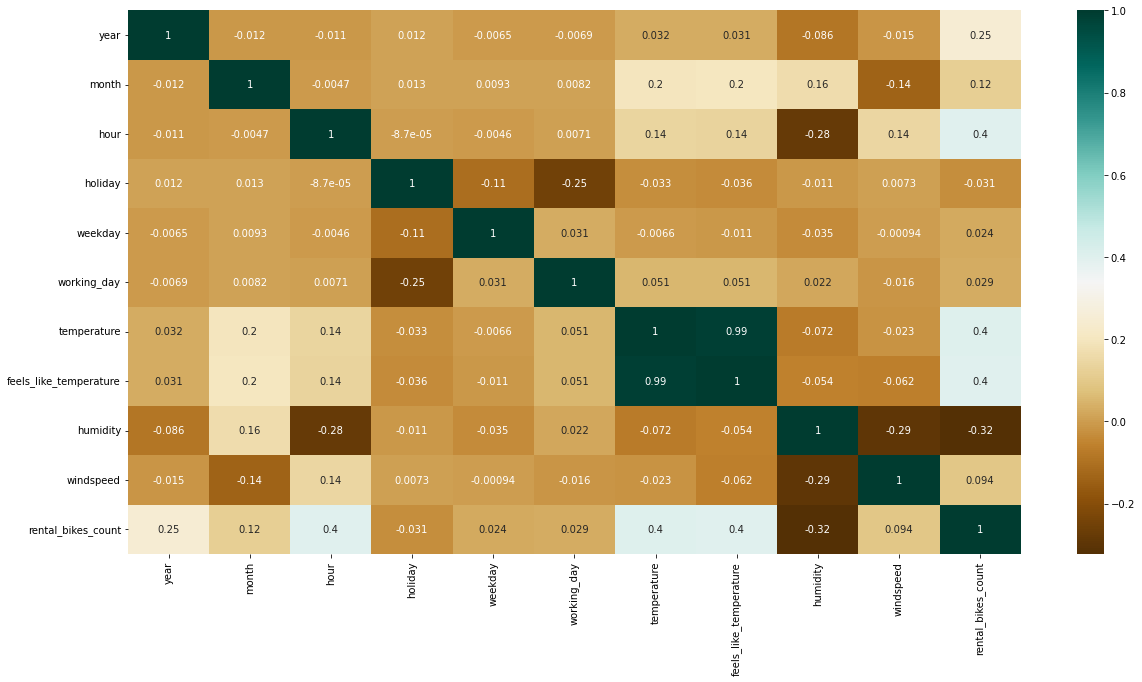

In [161]:
cat_columns =['year', 'month', 'hour', 'holiday', 'weekday', 'working_day',
       'temperature', 'feels_like_temperature',
       'humidity', 'windspeed', 'rental_bikes_count']
for i in cat_columns:
    df[i] = df[i].astype(float)

corr = df[list(cat_columns)].corr()
plt.figure(figsize= (20,10))
sns.heatmap(corr,annot = True, cmap = 'BrBG')
plt.show()

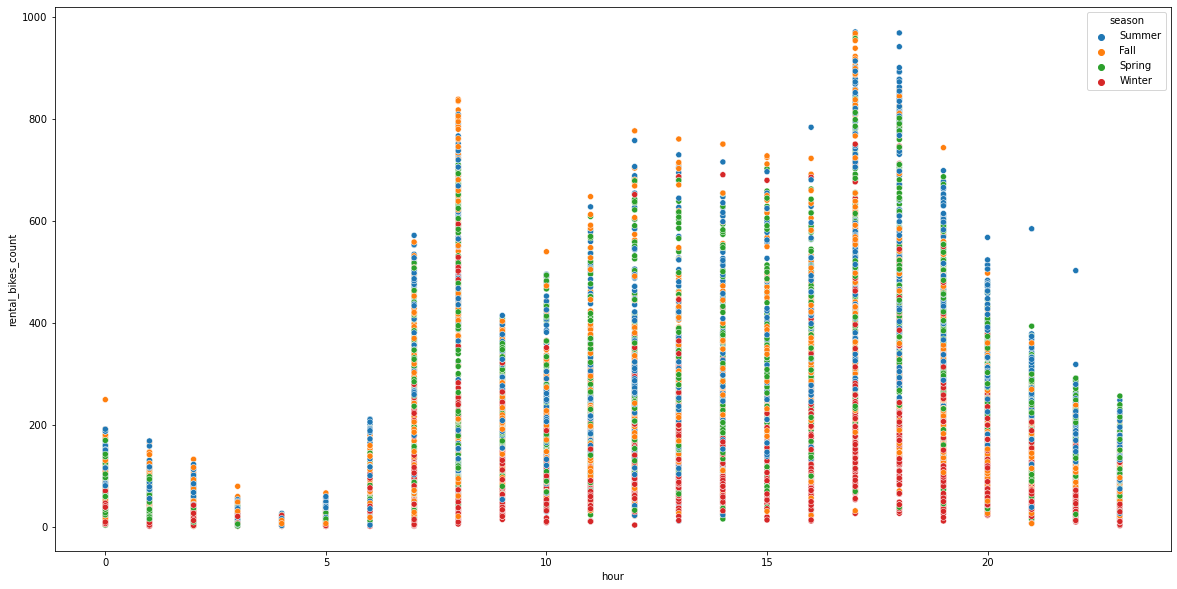

In [162]:
plt.figure(figsize = (20,10))
sns.scatterplot(x = df['hour'],y = df['rental_bikes_count'],hue = df['season'])
plt.show()


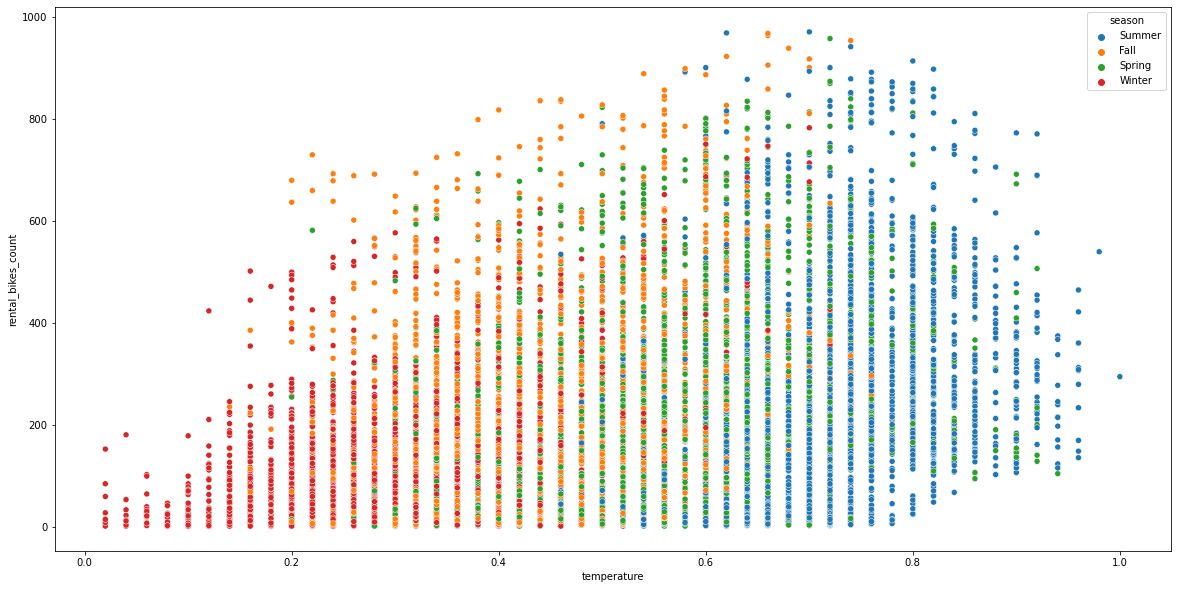

In [163]:
plt.figure(figsize = (20,10))
sns.scatterplot(x = df['temperature'],y = df['rental_bikes_count'],hue = df['season'])
plt.show()


### Data cleaning

In [164]:
# Choose label encoding, since there are multiple columns with the same build
df = df.replace(to_replace=['Heavy rain, heavy snow or thunderstorm','Light snow or light rain','Misty and/or cloudy','Clear or partly cloudy'], value = [0,0,1,2])
df = df.replace(to_replace=['Summer','Winter','Fall','Spring'], value = [0,1,2,3])

### Data preprocessing

In [165]:
X,y = df.drop('rental_bikes_count', axis = 1).copy(), df['rental_bikes_count'].copy()
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.4,random_state=100)

# PIPELINES
DT_regressor = make_pipeline(DecisionTreeRegressor(max_depth=10))
RF_regressor = make_pipeline(RandomForestRegressor(n_estimators=100, random_state=10,n_jobs=-1))

# Testign and fitting the split 
DT_regressor.fit(X_train,y_train)
RF_regressor.fit(X_train,y_train)

print('Train accuracy DT: {0:.5f}'.format(DT_regressor.score(X_train, y_train)))
print('Test accuracy DT: {0:.5f}'.format(DT_regressor.score(X_test, y_test)))

print('Train accuracy RF: {0:.5f}'.format(RF_regressor.score(X_train, y_train)))
print('Test accuracy RF: {0:.5f}'.format(RF_regressor.score(X_test, y_test)))

Train accuracy DT: 0.93511
Test accuracy DT: 0.88462
Train accuracy RF: 0.99134
Test accuracy RF: 0.93779


## Bins Model

In [167]:
# Bins Model
dfc = df.copy()
dfc = pd.get_dummies(dfc, columns = ['hour','month','weekday'])
forest = RandomForestClassifier(criterion='gini',n_estimators=60,random_state= 100,max_depth= 20,n_jobs=-1)
svm = make_pipeline(SVC(kernel='rbf', C=20, random_state=100))

binned = []
for i in range(2,11):
    y_bin= pd.cut(dfc['rental_bikes_count'], bins= i, labels=False)
    
    Xc = dfc.drop('rental_bikes_count', axis = 1).copy()
    Xc_train,Xc_test,yc_train,yc_test = train_test_split(Xc,y_bin,test_size=0.4,random_state=100)

    forest.fit(Xc_train, yc_train)
    FTrain = forest.score(Xc_train, yc_train)
    FTest  = forest.score(Xc_test, yc_test)

    sc = StandardScaler()
    sc.fit(Xc_train)

    Xc_train_sc = sc.transform(Xc_train)
    Xc_test_sc = sc.transform(Xc_test)

    
    svm.fit(Xc_train_sc, yc_train)
    svmtrain = svm.score(Xc_train_sc, yc_train)
    svmtest= svm.score(Xc_test_sc, yc_test)

    binned.append ([i,svmtrain,svmtest,FTrain,FTest])

table = pd.DataFrame(binned , columns=['bins number','SVM Train','SVM Test','Random Forest Train',' Random Forest Test'])

table

,bins number,SVM Train,SVM Test,Random Forest Train,Random Forest Test
0,2,0.995464,0.963861,0.999433,0.960459
1,3,0.993622,0.927296,0.992771,0.911139
2,4,0.989086,0.890944,0.986676,0.875850
3,5,0.986393,0.844600,0.981999,0.829294
4,6,0.981715,0.811862,0.975478,0.783163
5,7,0.982282,0.780400,0.981999,0.754464
6,8,0.978313,0.758929,0.973919,0.740009
7,9,0.977746,0.731080,0.972927,0.701956
8,10,0.973777,0.702168,0.975195,0.677934
